In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict
from kmodes.kmodes import KModes
from matplotlib import pyplot as plt
from prince import FAMD, MCA
from sklearn import datasets, decomposition
from sklearn import cluster as cl
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

### Business context: 
A bank wants to sell products to its customers, and it seeks to understand its customers better in order to create targeted products for them.
### Business question: 
Cluster customers of the bank by their banking behaviours, to create personas with shared behavioural trends that the bank and create targeted products to.

In [4]:
customer = pd.read_csv("../../Data/master_data/twm_customer.csv", sep = ';')
customer.head()

,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,street_nbr,street_name,postal_code,city_name,state_code
0,1362691,26150,46,5,1,M,2,,Donald ...,Marek ...,8298,Second ...,89194,Las Vegas,NV
1,1362487,6605,71,1,0,M,2,,ChingDyi ...,Moussavi ...,10603,Daffodil ...,90159,Los Angeles,CA
2,1363160,18548,38,8,0,F,1,,Rosa ...,Johnston ...,8817,Figueroa ...,90024,Los Angeles,CA
3,1362752,47668,54,3,0,F,1,,Lisa ...,Martin ...,676,Humble ...,90172,Los Angeles,CA
4,1362548,44554,59,9,2,F,4,,Barbara ...,O'Malley ...,6578,C ...,10138,New York City,NY


In [5]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cust_id          747 non-null    int64 
 1   income           747 non-null    int64 
 2   age              747 non-null    int64 
 3   years_with_bank  747 non-null    int64 
 4   nbr_children     747 non-null    int64 
 5   gender           747 non-null    object
 6   marital_status   747 non-null    int64 
 7   name_prefix      747 non-null    object
 8   first_name       747 non-null    object
 9   last_name        747 non-null    object
 10  street_nbr       747 non-null    int64 
 11  street_name      747 non-null    object
 12  postal_code      747 non-null    int64 
 13  city_name        747 non-null    object
 14  state_code       747 non-null    object
dtypes: int64(8), object(7)
memory usage: 87.7+ KB


In [6]:
customer.describe()

,cust_id,income,age,years_with_bank,nbr_children,marital_status,street_nbr,postal_code
count,7.470000e+02,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000
mean,1.362991e+06,22728.281124,42.479250,3.907631,0.714859,1.882195,8523.109772,59502.690763
std,2.925255e+02,22207.221405,19.114879,2.675634,1.103410,0.892051,5219.488263,31205.926508
min,1.362480e+06,0.000000,13.000000,0.000000,0.000000,1.000000,196.000000,2149.000000
25%,1.362732e+06,7118.500000,28.000000,2.000000,0.000000,1.000000,4295.500000,33145.000000
50%,1.362993e+06,17242.000000,42.000000,4.000000,0.000000,2.000000,8001.000000,64132.000000
75%,1.363244e+06,31338.000000,56.000000,6.000000,1.000000,2.000000,12039.000000,90082.000000
max,1.363495e+06,144157.000000,89.000000,9.000000,5.000000,4.000000,19940.000000,98186.000000


In [9]:
accounts = pd.read_csv("../../Data/master_data/twm_accounts.csv", sep = ';')
accounts.head()

,acct_nbr,cust_id,acct_type,account_active,acct_start_date,acct_end_date,starting_balance,ending_balance
0,13628063,1362806,SV,Y,10.12.1995,NaN,1430.22,284.58
1,4561143213627090,1362709,CC,Y,15.3.1993,NaN,266.34,496.15
2,4561143213628360,1362836,CC,Y,18.3.1992,NaN,55.90,1000.00
3,13633112,1363311,CK,Y,6.7.1995,NaN,11017.13,968.46
4,4561143213633610,1363361,CC,Y,17.6.1994,NaN,849.37,462.28


In [14]:
accounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1409 entries, 0 to 1408
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acct_nbr          1409 non-null   int64  
 1   cust_id           1409 non-null   int64  
 2   acct_type         1409 non-null   object 
 3   account_active    1409 non-null   object 
 4   acct_start_date   1409 non-null   object 
 5   acct_end_date     143 non-null    object 
 6   starting_balance  1409 non-null   float64
 7   ending_balance    1409 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 88.2+ KB


In [15]:
accounts.describe()

,acct_nbr,cust_id,starting_balance,ending_balance
count,1.409000e+03,1.409000e+03,1409.00000,1409.000000
mean,1.514986e+15,1.362989e+06,1435.35357,1011.754336
std,2.148991e+15,2.940584e+02,2186.69662,1559.986310
min,1.362480e+07,1.362480e+06,0.00000,0.000000
25%,1.362852e+07,1.362727e+06,189.23000,140.000000
50%,1.363252e+07,1.362985e+06,487.69000,553.610000
75%,4.561143e+15,1.363251e+06,2178.79000,1188.570000
max,4.561143e+15,1.363495e+06,27072.38000,22432.780000


In [10]:
transactions = pd.read_csv("../../Data/master_data/twm_transactions.csv", sep = ';')
transactions.head()

,tran_id,acct_nbr,tran_amt,principal_amt,interest_amt,new_balance,tran_date,tran_time,channel,tran_code
0,27,13625623,0.00,0.00,0.0,3753.34,21.10.1995,121656,A,IQ
1,97,13628392,0.00,0.00,0.0,254.49,5.2.1995,153053,V,IQ
2,21,13630842,-97.57,-97.57,0.0,3819.56,23.7.1995,0,P,WD
3,44,13631412,-0.15,-0.15,0.0,224.05,30.1.1995,0,,FK
4,31,13625722,0.00,0.00,0.0,240.55,25.1.1995,204521,B,IQ


In [17]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77580 entries, 0 to 77579
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tran_id        77580 non-null  int64  
 1   acct_nbr       77580 non-null  int64  
 2   tran_amt       77580 non-null  float64
 3   principal_amt  77580 non-null  float64
 4   interest_amt   77580 non-null  float64
 5   new_balance    77580 non-null  float64
 6   tran_date      77580 non-null  object 
 7   tran_time      77580 non-null  int64  
 8   channel        77580 non-null  object 
 9   tran_code      77580 non-null  object 
dtypes: float64(4), int64(3), object(3)
memory usage: 5.9+ MB


In [18]:
transactions.describe()

,tran_id,acct_nbr,tran_amt,principal_amt,interest_amt,new_balance,tran_time
count,77580.000000,7.758000e+04,77580.000000,77580.000000,77580.000000,77580.000000,77580.000000
mean,38.228332,1.185674e+15,-7.748275,-8.509662,0.762784,571.571177,104277.077984
std,27.838521,2.000564e+15,312.684674,311.006502,4.427059,2158.948572,87527.030938
min,1.000000,1.362480e+07,-3312.410000,-3312.410000,0.000000,-17300.000000,0.000000
25%,15.000000,1.362824e+07,-100.000000,-100.000000,0.000000,0.000000,0.000000
50%,32.000000,1.363199e+07,-1.815000,-1.815000,0.000000,180.400000,110626.000000
75%,59.000000,4.561143e+15,0.170000,0.000000,0.000000,957.252500,184245.250000
max,155.000000,4.561143e+15,17464.520000,17300.000000,164.520000,29868.390000,235959.000000


In [11]:
# Function to strip whitepsace from ends of string, but will take any input and return it if it's not a string
def fix(input):
    try:
        input = input.strip()
    except:
        pass
    return input

In [12]:
# Fix all the dataframes, removing whitespace from start and end of strings
for colname in customer.columns:
    customer[colname] = customer[colname].apply(fix)

for colname in accounts.columns:
    accounts[colname] = accounts[colname].apply(fix)

for colname in transactions.columns:
    transactions[colname] = transactions[colname].apply(fix)

In [13]:
# Create a new df which contains information from the 3 master datasets
bk_behaviour = pd.DataFrame()
bk_behaviour["cust_id"] = customer['cust_id']
bk_behaviour.head()

,cust_id
0,1362691
1,1362487
2,1363160
3,1362752
4,1362548


In [14]:
# Right merge bk_behaviour with accounts on cust_id to get info on acct_type, starting_balance, etc...
bk_behaviour = pd.merge(bk_behaviour, accounts, on='cust_id', how='right')
bk_behaviour.head()

,cust_id,acct_nbr,acct_type,account_active,acct_start_date,acct_end_date,starting_balance,ending_balance
0,1362806,13628063,SV,Y,10.12.1995,NaN,1430.22,284.58
1,1362709,4561143213627090,CC,Y,15.3.1993,NaN,266.34,496.15
2,1362836,4561143213628360,CC,Y,18.3.1992,NaN,55.90,1000.00
3,1363311,13633112,CK,Y,6.7.1995,NaN,11017.13,968.46
4,1363361,4561143213633610,CC,Y,17.6.1994,NaN,849.37,462.28


In [15]:
# Drop columns that aren't useful
bk_behaviour = bk_behaviour.drop(['acct_start_date', 'acct_end_date'], axis=1)

In [16]:
# Change Y and N to 1 and 0
bk_behaviour["account_active"] = bk_behaviour["account_active"].map({"N": 0, "Y": 1})

In [19]:
# Left merge transactions with accounts on acct_nbr to show which account type (e.g. cc, ck, etc) was used in a transaction 
transactions['acct_nbr'] = transactions['acct_nbr'].astype(str)
accounts['acct_nbr'] = accounts['acct_nbr'].astype(str)
transactions1 = pd.merge(transactions, accounts[['acct_nbr', 'acct_type']], on='acct_nbr', how='left')
transactions1.head()

,tran_id,acct_nbr,tran_amt,principal_amt,interest_amt,new_balance,tran_date,tran_time,channel,tran_code,acct_type
0,27,13625623,0.00,0.00,0.0,3753.34,21.10.1995,121656,A,IQ,SV
1,97,13628392,0.00,0.00,0.0,254.49,5.2.1995,153053,V,IQ,CK
2,21,13630842,-97.57,-97.57,0.0,3819.56,23.7.1995,0,P,WD,CK
3,44,13631412,-0.15,-0.15,0.0,224.05,30.1.1995,0,,FK,CK
4,31,13625722,0.00,0.00,0.0,240.55,25.1.1995,204521,B,IQ,CK


In [29]:
# Create a df containing the average withdraw amount for each cc acct_nbr
transactions1_filtered1 = transactions1[(transactions1["acct_type"] == "CC") & (transactions1["tran_amt"] < 0)]
grouped1 = transactions1_filtered1.groupby("acct_nbr")
transactions_grouped1 = grouped1['tran_amt'].mean().reset_index()
transactions_grouped1.rename(columns={'tran_amt': 'cc_av_wd'}, inplace=True)
transactions_grouped1["acct_nbr"] = transactions_grouped1["acct_nbr"].astype(str)
transactions_grouped1.head()

,acct_nbr,cc_av_wd
0,4561143213624800,-191.321176
1,4561143213624840,-116.890513
2,4561143213624850,-117.459474
3,4561143213624870,-121.323077
4,4561143213624890,-244.068400


In [30]:
# Create a df containing the average payment amount for each cc acct_nbr
transactions1_filtered2 = transactions1[(transactions1["acct_type"] == "CC") & (transactions1["tran_amt"] > 0)]
grouped2 = transactions1_filtered2.groupby("acct_nbr")
transactions_grouped2 = grouped2['tran_amt'].mean().reset_index()
transactions_grouped2.rename(columns={'tran_amt': 'cc_av_pm'}, inplace=True)
transactions_grouped2["acct_nbr"] = transactions_grouped2["acct_nbr"].astype(str)
transactions_grouped2.head()

,acct_nbr,cc_av_pm
0,4561143213624800,433.426667
1,4561143213624840,456.883333
2,4561143213624850,494.496667
3,4561143213624870,404.702500
4,4561143213624890,866.210000


In [43]:
# Number of withdraws from cc
transactions1_filtered3 = transactions1[(transactions1["acct_type"] == "CC") & (transactions1["tran_amt"] < 0)]
grouped3 = transactions1_filtered3.groupby("acct_nbr")
transactions_grouped3 = grouped3['tran_amt'].agg(lambda x: len(x)).reset_index()
transactions_grouped3.rename(columns={'tran_amt': 'cc_n_wd'}, inplace=True)
transactions_grouped3["acct_nbr"] = transactions_grouped3["acct_nbr"].astype(str)
transactions_grouped3.head()

,acct_nbr,cc_n_wd
0,4561143213624800,17
1,4561143213624840,39
2,4561143213624850,57
3,4561143213624870,26
4,4561143213624890,25


In [44]:
# Number of payments to cc
transactions1_filtered4 = transactions1[(transactions1["acct_type"] == "CC") & (transactions1["tran_amt"] > 0)]
grouped4 = transactions1_filtered4.groupby("acct_nbr")
transactions_grouped4 = grouped4['tran_amt'].agg(lambda x: len(x)).reset_index()
transactions_grouped4.rename(columns={'tran_amt': 'cc_n_pm'}, inplace=True)
transactions_grouped4["acct_nbr"] = transactions_grouped4["acct_nbr"].astype(str)
transactions_grouped4.head()

,acct_nbr,cc_n_pm
0,4561143213624800,12
1,4561143213624840,12
2,4561143213624850,12
3,4561143213624870,4
4,4561143213624890,9


In [45]:
# Create a df containing the average withdraw amount for each cq acct_nbr
transactions1_filtered5 = transactions1[(transactions1["acct_type"] == "CK") & (transactions1["tran_amt"] < 0)]
grouped5 = transactions1_filtered5.groupby("acct_nbr")
transactions_grouped5 = grouped5['tran_amt'].mean().reset_index()
transactions_grouped5.rename(columns={'tran_amt': 'cq_av_wd'}, inplace=True)
transactions_grouped5["acct_nbr"] = transactions_grouped5["acct_nbr"].astype(str)
transactions_grouped5.head()

,acct_nbr,cq_av_wd
0,13624802,-102.566957
1,13624842,-71.081667
2,13624852,-77.378060
3,13624862,-112.306667
4,13624872,-72.242500


In [46]:
# Create a df containing the average deposit amount for each cq acct_nbr
transactions1_filtered6 = transactions1[(transactions1["acct_type"] == "CK") & (transactions1["tran_amt"] > 0)]
grouped6 = transactions1_filtered6.groupby("acct_nbr")
transactions_grouped6 = grouped6['tran_amt'].mean().reset_index()
transactions_grouped6.rename(columns={'tran_amt': 'cq_av_dp'}, inplace=True)
transactions_grouped6["acct_nbr"] = transactions_grouped6["acct_nbr"].astype(str)
transactions_grouped6.head()

,acct_nbr,cq_av_dp
0,13624802,488.009286
1,13624842,162.483750
2,13624852,313.752500
3,13624862,5.433846
4,13624872,66.647857


In [47]:
# Number of withdraws from cq
transactions1_filtered7 = transactions1[(transactions1["acct_type"] == "CK") & (transactions1["tran_amt"] < 0)]
grouped7 = transactions1_filtered7.groupby("acct_nbr")
transactions_grouped7 = grouped7['tran_amt'].agg(lambda x: len(x)).reset_index()
transactions_grouped7.rename(columns={'tran_amt': 'cq_n_wd'}, inplace=True)
transactions_grouped7["acct_nbr"] = transactions_grouped7["acct_nbr"].astype(str)
transactions_grouped7.head()

,acct_nbr,cq_n_wd
0,13624802,69
1,13624842,72
2,13624852,67
3,13624862,9
4,13624872,32


In [48]:
# Number of deposits to cq
transactions1_filtered8 = transactions1[(transactions1["acct_type"] == "CK") & (transactions1["tran_amt"] > 0)]
grouped8 = transactions1_filtered8.groupby("acct_nbr")
transactions_grouped8 = grouped8['tran_amt'].agg(lambda x: len(x)).reset_index()
transactions_grouped8.rename(columns={'tran_amt': 'cq_n_dp'}, inplace=True)
transactions_grouped8["acct_nbr"] = transactions_grouped8["acct_nbr"].astype(str)
transactions_grouped8.head()

,acct_nbr,cq_n_dp
0,13624802,14
1,13624842,16
2,13624852,16
3,13624862,13
4,13624872,14


In [49]:
# Create a df containing the average withdraw amount for each SV acct_nbr
transactions1_filtered9 = transactions1[(transactions1["acct_type"] == "SV") & (transactions1["tran_amt"] < 0)]
grouped9 = transactions1_filtered9.groupby("acct_nbr")
transactions_grouped9 = grouped9['tran_amt'].mean().reset_index()
transactions_grouped9.rename(columns={'tran_amt': 'sv_av_wd'}, inplace=True)
transactions_grouped9["acct_nbr"] = transactions_grouped9["acct_nbr"].astype(str)
transactions_grouped9.head()

,acct_nbr,sv_av_wd
0,13624803,-358.210000
1,13624843,-257.342500
2,13624863,-85.782222
3,13624873,-109.025714
4,13624893,-315.612500


In [50]:
# Create a df containing the average deposit amount for each SV acct_nbr
transactions1_filtered10 = transactions1[(transactions1["acct_type"] == "SV") & (transactions1["tran_amt"] > 0)]
grouped10 = transactions1_filtered10.groupby("acct_nbr")
transactions_grouped10 = grouped10['tran_amt'].mean().reset_index()
transactions_grouped10.rename(columns={'tran_amt': 'sv_av_dp'}, inplace=True)
transactions_grouped10["acct_nbr"] = transactions_grouped10["acct_nbr"].astype(str)
transactions_grouped10.head()

,acct_nbr,sv_av_dp
0,13624803,106.397778
1,13624843,102.035517
2,13624863,37.737500
3,13624873,15.542500
4,13624893,58.390667


In [51]:
# Number of withdraws from sv
transactions1_filtered11 = transactions1[(transactions1["acct_type"] == "SV") & (transactions1["tran_amt"] < 0)]
grouped11 = transactions1_filtered11.groupby("acct_nbr")
transactions_grouped11 = grouped11['tran_amt'].agg(lambda x: len(x)).reset_index()
transactions_grouped11.rename(columns={'tran_amt': 'sv_n_wd'}, inplace=True)
transactions_grouped11["acct_nbr"] = transactions_grouped11["acct_nbr"].astype(str)
transactions_grouped11.head()

,acct_nbr,sv_n_wd
0,13624803,4
1,13624843,4
2,13624863,9
3,13624873,7
4,13624893,4


In [52]:
# Number of deposits to sv
transactions1_filtered12 = transactions1[(transactions1["acct_type"] == "SV") & (transactions1["tran_amt"] > 0)]
grouped12 = transactions1_filtered12.groupby("acct_nbr")
transactions_grouped12 = grouped12['tran_amt'].agg(lambda x: len(x)).reset_index()
transactions_grouped12.rename(columns={'tran_amt': 'sv_n_dp'}, inplace=True)
transactions_grouped12["acct_nbr"] = transactions_grouped12["acct_nbr"].astype(str)
transactions_grouped12.head()

,acct_nbr,sv_n_dp
0,13624803,18
1,13624843,29
2,13624863,16
3,13624873,8
4,13624893,15


In [53]:
transactions1['acct_nbr'] = transactions1['acct_nbr'].astype(str)
bk_behaviour["acct_nbr"] = bk_behaviour["acct_nbr"].astype(str)

In [57]:
bk_behaviour_m = bk_behaviour.merge(transactions_grouped1, on='acct_nbr', how='left')

bk_behaviour_m = bk_behaviour_m.merge(transactions_grouped2, on='acct_nbr', how='left')

bk_behaviour_m = bk_behaviour_m.merge(transactions_grouped3, on='acct_nbr', how='left')

bk_behaviour_m = bk_behaviour_m.merge(transactions_grouped4, on='acct_nbr', how='left')

bk_behaviour_m = bk_behaviour_m.merge(transactions_grouped5, on='acct_nbr', how='left')

bk_behaviour_m = bk_behaviour_m.merge(transactions_grouped6, on='acct_nbr', how='left')

bk_behaviour_m = bk_behaviour_m.merge(transactions_grouped7, on='acct_nbr', how='left')

bk_behaviour_m = bk_behaviour_m.merge(transactions_grouped8, on='acct_nbr', how='left')

bk_behaviour_m = bk_behaviour_m.merge(transactions_grouped9, on='acct_nbr', how='left')

bk_behaviour_m = bk_behaviour_m.merge(transactions_grouped10, on='acct_nbr', how='left')

bk_behaviour_m = bk_behaviour_m.merge(transactions_grouped11, on='acct_nbr', how='left')

bk_behaviour_m = bk_behaviour_m.merge(transactions_grouped12, on='acct_nbr', how='left')

bk_behaviour_m.head()

,cust_id,acct_nbr,acct_type,account_active,starting_balance,ending_balance,cc_av_wd,cc_av_pm,cc_n_wd,cc_n_pm,cq_av_wd,cq_av_dp,cq_n_wd,cq_n_dp,sv_av_wd,sv_av_dp,sv_n_wd,sv_n_dp
0,1362806,13628063,SV,1,1430.22,284.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-172.314375,84.81,16.0,19.0
1,1362709,4561143213627090,CC,1,266.34,496.15,-112.667500,356.720000,40.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1362836,4561143213628360,CC,1,55.90,1000.00,-80.719583,93.571667,24.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1363311,13633112,CK,1,11017.13,968.46,NaN,NaN,NaN,NaN,-271.653559,284.709048,59.0,21.0,NaN,NaN,NaN,NaN
4,1363361,4561143213633610,CC,1,849.37,462.28,-150.086563,472.892727,32.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
bk_behaviour_m['end_start_ratio'] = bk_behaviour_m.apply(lambda x: np.nan if x['starting_balance'] == 0 else x['ending_balance'] / x['starting_balance'], axis=1)

In [68]:
bk_behaviour_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1409 entries, 0 to 1408
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cust_id           1409 non-null   int64  
 1   acct_nbr          1409 non-null   object 
 2   acct_type         1409 non-null   object 
 3   account_active    1409 non-null   int64  
 4   starting_balance  1409 non-null   float64
 5   ending_balance    1409 non-null   float64
 6   cc_av_wd          435 non-null    float64
 7   cc_av_pm          450 non-null    float64
 8   cc_n_wd           435 non-null    float64
 9   cc_n_pm           450 non-null    float64
 10  cq_av_wd          517 non-null    float64
 11  cq_av_dp          517 non-null    float64
 12  cq_n_wd           517 non-null    float64
 13  cq_n_dp           517 non-null    float64
 14  sv_av_wd          343 non-null    float64
 15  sv_av_dp          420 non-null    float64
 16  sv_n_wd           343 non-null    float64


In [ ]:
bk_behaviour_m.head()

,cust_id,acct_nbr,acct_type,account_active,starting_balance,ending_balance,cc_av_wd,cc_av_pm,cc_n_wd,cc_n_pm,cq_av_wd,cq_av_dp,cq_n_wd,cq_n_dp,sv_av_wd,sv_av_dp,sv_n_wd,sv_n_dp,end_start_ratio
0,1362806,13628063,SV,1,1430.22,284.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-172.314375,84.81,16.0,19.0,0.198976
1,1362709,4561143213627090,CC,1,266.34,496.15,-112.667500,356.720000,40.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.862844
2,1362836,4561143213628360,CC,1,55.90,1000.00,-80.719583,93.571667,24.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.889088
3,1363311,13633112,CK,1,11017.13,968.46,NaN,NaN,NaN,NaN,-271.653559,284.709048,59.0,21.0,NaN,NaN,NaN,NaN,0.087905
4,1363361,4561143213633610,CC,1,849.37,462.28,-150.086563,472.892727,32.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.544262


In [73]:
bk_behaviour_m.to_csv('../../Data/master_data/bk_behaviour.csv', index = False)

In [74]:
bk_behaviour_m2 = pd.read_csv('../../Data/master_data/bk_behaviour.csv')

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


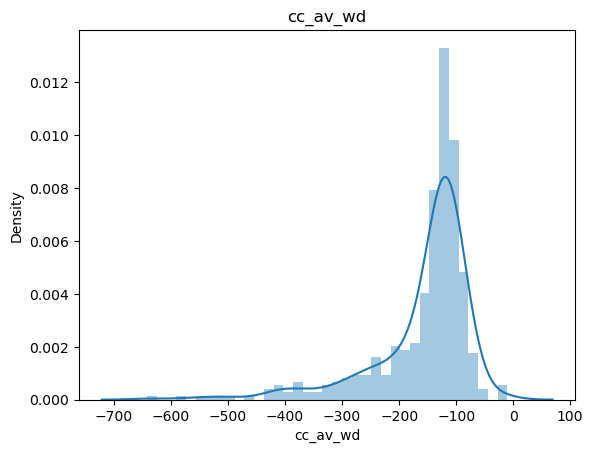

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


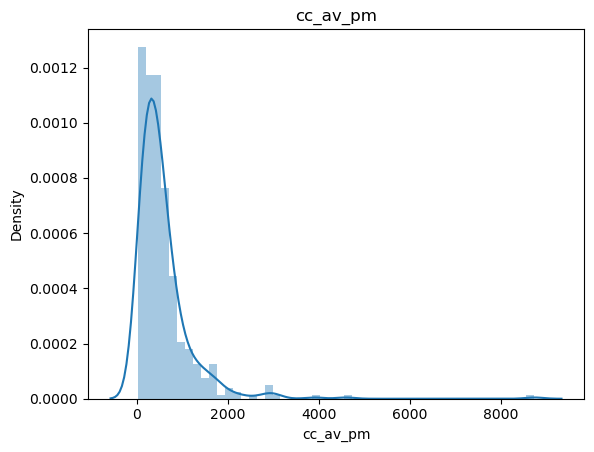

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


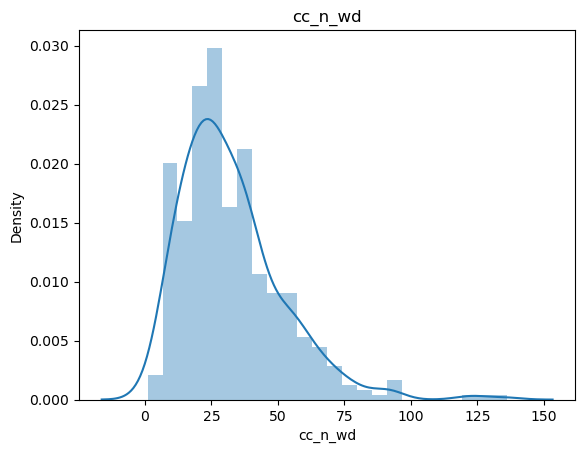

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


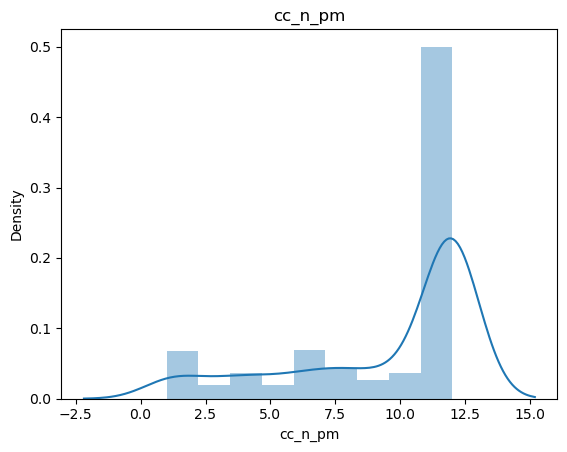

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


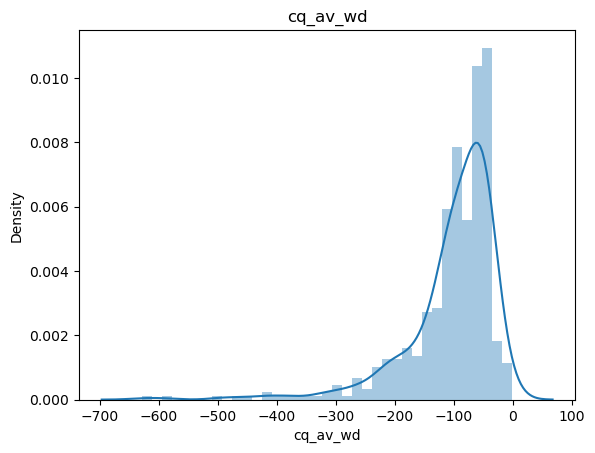

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


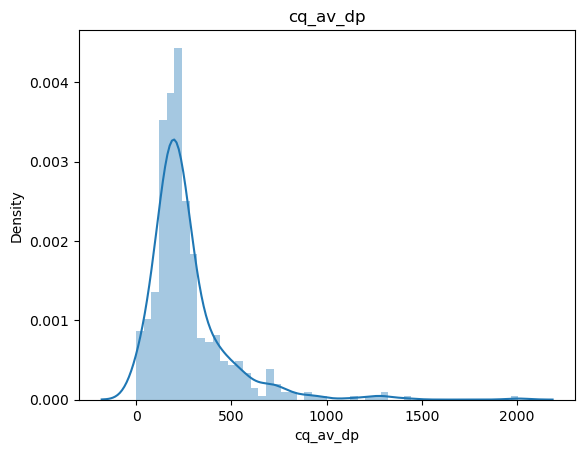

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


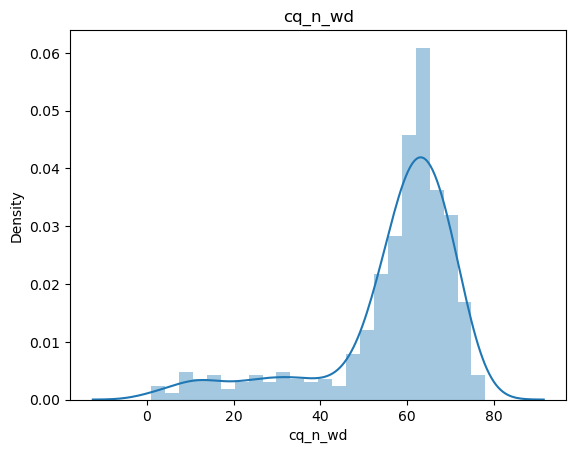

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


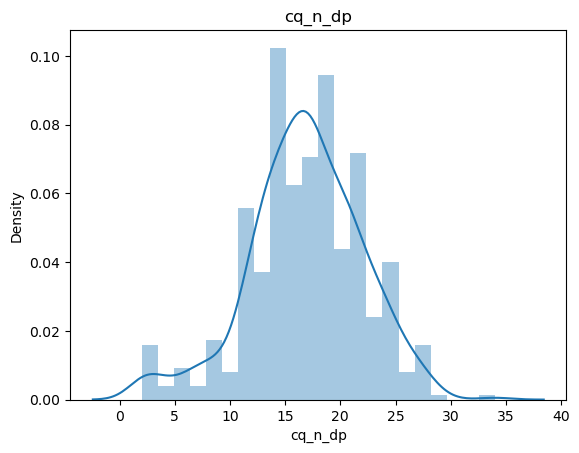

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


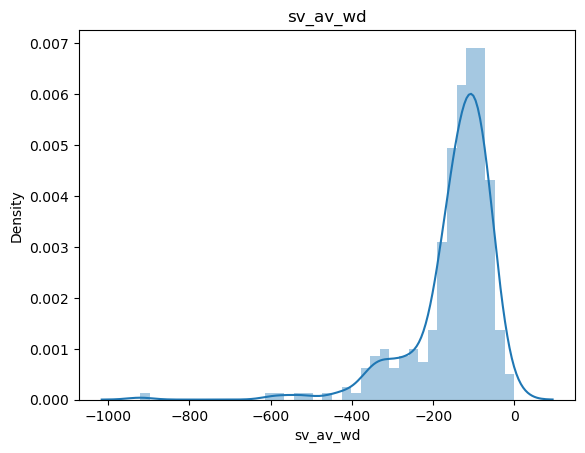

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


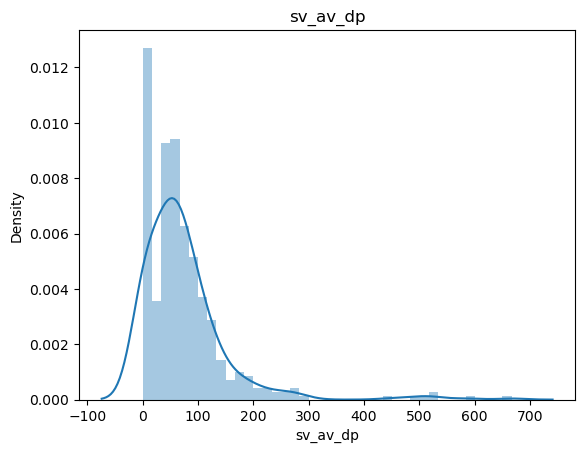

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


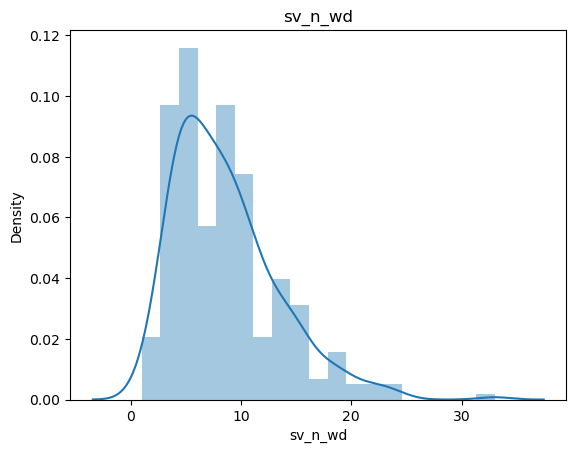

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


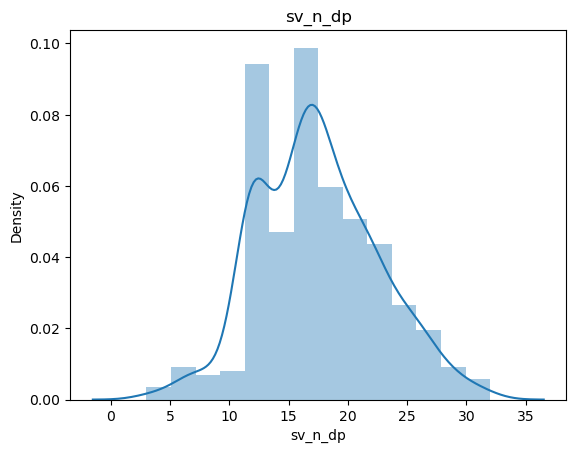

/Users/brigitte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


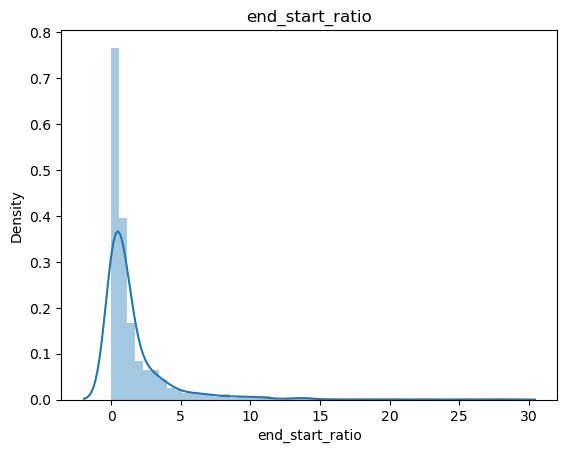

In [75]:
column_names = bk_behaviour_m2.columns[-13:]

for column_name in column_names:
    sns.distplot(bk_behaviour_m2[column_name])
    plt.title(column_name)
    plt.show()

In [76]:
bk_behaviour_m2.describe()

,cust_id,acct_nbr,account_active,starting_balance,ending_balance,cc_av_wd,cc_av_pm,cc_n_wd,cc_n_pm,cq_av_wd,cq_av_dp,cq_n_wd,cq_n_dp,sv_av_wd,sv_av_dp,sv_n_wd,sv_n_dp,end_start_ratio
count,1.409000e+03,1.409000e+03,1409.000000,1409.00000,1409.000000,435.000000,450.000000,435.000000,450.000000,517.000000,517.000000,517.000000,517.000000,343.000000,420.000000,343.000000,420.000000,1269.000000
mean,1.362989e+06,1.514986e+15,0.898510,1435.35357,1011.754336,-158.083173,584.468938,32.413793,9.477778,-103.431975,268.415672,56.765957,16.827853,-148.486552,73.734523,8.594752,17.409524,1.592953
std,2.940584e+02,2.148991e+15,0.302084,2186.69662,1559.986310,88.914632,671.634635,19.355367,3.597908,79.100046,210.447172,15.628356,5.147378,101.516172,82.460070,4.773425,5.053783,2.713818
min,1.362480e+06,1.362480e+07,0.000000,0.00000,0.000000,-642.432000,23.534167,1.000000,1.000000,-628.386393,0.317500,1.000000,2.000000,-921.365000,0.150000,1.000000,3.000000,0.000000
25%,1.362727e+06,1.362852e+07,1.000000,189.23000,140.000000,-175.118582,215.793750,19.000000,7.000000,-122.168750,156.366923,54.000000,14.000000,-171.473750,29.216771,5.000000,13.000000,0.138996
50%,1.362985e+06,1.363252e+07,1.000000,487.69000,553.610000,-127.285934,416.745833,28.000000,12.000000,-83.415102,215.642000,61.000000,17.000000,-123.886923,58.558778,8.000000,17.000000,0.820903
75%,1.363251e+06,4.561143e+15,1.000000,2178.79000,1188.570000,-109.143397,695.434167,41.000000,12.000000,-52.720000,305.308000,67.000000,20.000000,-87.410000,92.587500,11.000000,21.000000,1.646219
max,1.363495e+06,4.561143e+15,1.000000,27072.38000,22432.780000,-10.000000,8735.140000,136.000000,12.000000,-0.750000,2005.706667,78.000000,34.000000,-0.750000,666.581818,33.000000,32.000000,28.490028


In [77]:
bk_behaviour_m2

,cust_id,acct_nbr,acct_type,account_active,starting_balance,ending_balance,cc_av_wd,cc_av_pm,cc_n_wd,cc_n_pm,cq_av_wd,cq_av_dp,cq_n_wd,cq_n_dp,sv_av_wd,sv_av_dp,sv_n_wd,sv_n_dp,end_start_ratio
0,1362806,13628063,SV,1,1430.22,284.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-172.314375,84.810,16.0,19.0,0.198976
1,1362709,4561143213627090,CC,1,266.34,496.15,-112.667500,356.720000,40.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.862844
2,1362836,4561143213628360,CC,1,55.90,1000.00,-80.719583,93.571667,24.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.889088
3,1363311,13633112,CK,1,11017.13,968.46,NaN,NaN,NaN,NaN,-271.653559,284.709048,59.0,21.0,NaN,NaN,NaN,NaN,0.087905
4,1363361,4561143213633610,CC,1,849.37,462.28,-150.086563,472.892727,32.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.544262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,1362556,4561143213625560,CC,0,1433.94,20.00,-241.581154,986.718750,26.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013948
1405,1362624,4561143213626240,CC,1,632.75,1400.00,-157.801351,428.359167,37.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.212564
1406,1362875,4561143213628750,CC,1,2810.91,3000.00,-102.835833,221.575000,24.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.067270
1407,1362654,13626543,SV,1,784.53,622.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-137.846000,35.144,5.0,15.0,0.793418


In [78]:
len(set(bk_behaviour_m2.cust_id))

665